In [106]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as spl
import statsmodels.graphics.gofplots as gpl

from arch import arch_model 

# 0. Загрузка данных

In [2]:
# https://bonds.finam.ru/issue/details018F500002/default.asp -- пример источника данных

bonds_file_names = ['/SU26205RMFS3_rates.csv', 
                 '/SU26209RMFS5_rates.csv',
                 '/SU26212RMFS9_rates.csv',
                 '/SU26215RMFS2_rates.csv', 
                 '/SU26217RMFS8_rates.csv']

bonds_names = [x[1:len('SU26209RMFS5')+1] for x in bonds_file_names]

shares_file_names = ["/SBER.ME.csv", 
                  '/GAZP.ME.csv', 
                  '/YNDX.ME.csv',
                  '/MGNT.ME.csv', 
                  '/GMKN.ME.csv',
                  '/MTSS.ME.csv', 
                  '/PIKK.ME.csv', 
                  '/AFLT.ME.csv', 
                  '/POLY.ME.csv', 
                  '/RSTI.ME.csv']

shares_names = [x[1:5] for x in shares_file_names]

currencies_file_names = ['/D_USD.csv',
                      '/D_CNY.csv']

currencies_names = [x[3:6] for x in currencies_file_names]

risks_file_names = ['/IMOEX.ME.csv',
                    '/BZ=F.csv',
                    '/RTS.csv']   

risks_names = [x.split('/')[1].split('.csv')[0] for x in risks_file_names]

bonds_folder = 'bonds'
shares_folder = 'shares'
currencies_folder = 'currencies'
risks_folder = 'risk_factors'

bonds = [bonds_folder + x for x in bonds_file_names]
shares = [shares_folder + x for x in shares_file_names]
currencies = [currencies_folder + x for x in currencies_file_names]
risks = [risks_folder + x for x in risks_file_names]
zero_bonds = risks_folder + '/zero_bonds.csv'
metals = risks_folder + '/refined_precious_metals.xlsx'

In [3]:
def load_df(bonds=bonds, bonds_names=bonds_names, 
            shares=shares, shares_names=shares_names,
            currencies=currencies, currencies_names=currencies_names,
            risks=risks, risks_names=risks_names,
            zero_bonds=zero_bonds, metals=metals):
#     Основной df
    main_df = pd.read_csv(bonds[0], index_col='<DATE>')
    main_df.index = pd.to_datetime(main_df.index, format='%Y%m%d')
    main_df = main_df[[]]
    main_df.index.names = ['Date']
#     Загрузка облигаций
    for i in range(len(bonds)):
        df = pd.read_csv(bonds[i], index_col='<DATE>')
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
        df = df[['<CLOSE>']].rename(columns={'<CLOSE>': bonds_names[i]})
        df.index.names = ['Date']
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка акций
    for i in range(len(shares)):
        df = pd.read_csv(shares[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': shares_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка валют
    for i in range(len(currencies)):
        df = pd.read_csv(currencies[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': currencies_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка рисков
    for i in range(len(risks)):
        df = pd.read_csv(risks[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': risks_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка металлов
    df = pd.read_excel(metals, index_col='Date')
    df.index = pd.to_datetime(df.index)
    main_df = main_df.join(df, how='left', on='Date')

#     Загрузка zero_bonds
    df = pd.read_csv(zero_bonds, index_col='Date')
    df.index = pd.to_datetime(df.index)
    main_df = main_df.join(df, how='left', on='Date')

#     Заполнение пропусков
    main_df.fillna(method='ffill', inplace=True)
    main_df.fillna(method='backfill', inplace=True)

    return main_df

Портфель и риски в отдельных датафремах

In [4]:
prices = load_df()

bonds = prices.iloc[:, 0:5]
shares = prices.iloc[:, 5:15]
currencies = prices.iloc[:, 15:17]
risk_factors = prices.iloc[:, 17:]

# ret = prices.pct_change()
# ret.dropna(inplace=True)

# bonds_ret = ret.iloc[:, 0:5]
# shares_ret = ret.iloc[:, 5:15]
# currencies_ret = ret.iloc[:, 15:17]
# risk_factors_ret = ret.iloc[:, 17:]

# 1. Описательная статистика риск-факторов

In [5]:
def plot_cor_matrix(risk_factors: pd.DataFrame) -> None:
    corr_matrix = risk_factors.corr()
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot()
    
    sns.heatmap(corr_matrix, annot=True)
    
    plt.show()

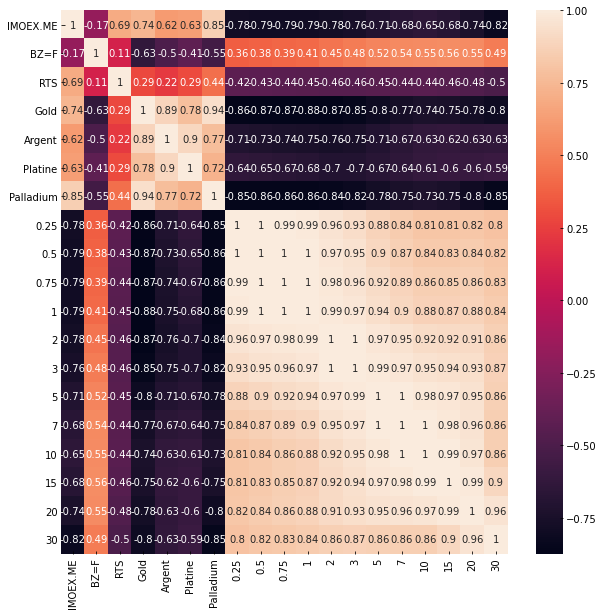

In [6]:
plot_cor_matrix(risk_factors)

In [7]:
def risk_factor_describe(risk_factor: pd.Series) -> None:
    risk_factor_name = risk_factor.name
    print(f"{'=' * 10} {risk_factor_name.upper()} {'=' * 10}")
    print(f"mean: {np.round(np.mean(risk_factor), 2)}")
    print(f"std: {np.round(np.std(risk_factor), 2)}")
    print(f"min: {np.round(np.min(risk_factor), 2)}")
    print(f"max: {np.round(np.max(risk_factor), 2)}")
    adfuller_pv = adfuller(risk_factor)[1]
    print(
        f"The Augmented Dickey-Fuller test, p-value: {adfuller_pv}, "
        f"series is {'non ' if adfuller_pv >= 0.05 else ''}stationary"
    )
    risk_factor_change = risk_factor.pct_change().iloc[1:]
    adfuller_pv = adfuller(risk_factor_change)[1]
    print(
        f"The Augmented Dickey-Fuller test for pct change, p-value: {adfuller_pv}, "
        f"series is {'non ' if adfuller_pv >= 0.05 else ''}stationary"
    )
    
    fig = plt.figure(figsize=(15, 15))
    
    ax = plt.subplot(511)
    sns.lineplot(x=risk_factor.index, y=risk_factor, ax=ax)
    plt.title('Price')
    
    ax = plt.subplot(512)
    sns.lineplot(x=risk_factor_change.index, y=risk_factor_change, ax=ax)
    plt.title('Price percent change')
    
    ax = plt.subplot(525)
    spl.plot_acf(risk_factor_change, lags=20, ax=ax)
    
    ax = plt.subplot(526)
    spl.plot_pacf(risk_factor_change, lags=20, ax=ax)
    
    ax = plt.subplot(527)
    normal_dist = gpl.ProbPlot(risk_factor_change, fit=True)
    normal_dist.qqplot(line='r', ax=ax)
    plt.title('Q-Q')
    
    ax = plt.subplot(528)
    normal_dist.ppplot(line='45', ax=ax)
    plt.title('P-P')
    
    ax = plt.subplot(529)
    normal_dist.probplot(line='r', ax=ax)
    plt.title('Prob')
    
    ax = plt.subplot(5, 2, 10)
    sns.distplot(risk_factor_change, ax=ax)
    plt.title('Distribution')
    
    plt.tight_layout()
    plt.show()

========== IMOEX.ME ==========
mean: 2478.9
std: 360.04
min: 1817.82
max: 3289.02
The Augmented Dickey-Fuller test, p-value: 0.8341597619769606, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.3281846425403031e-25, series is stationary


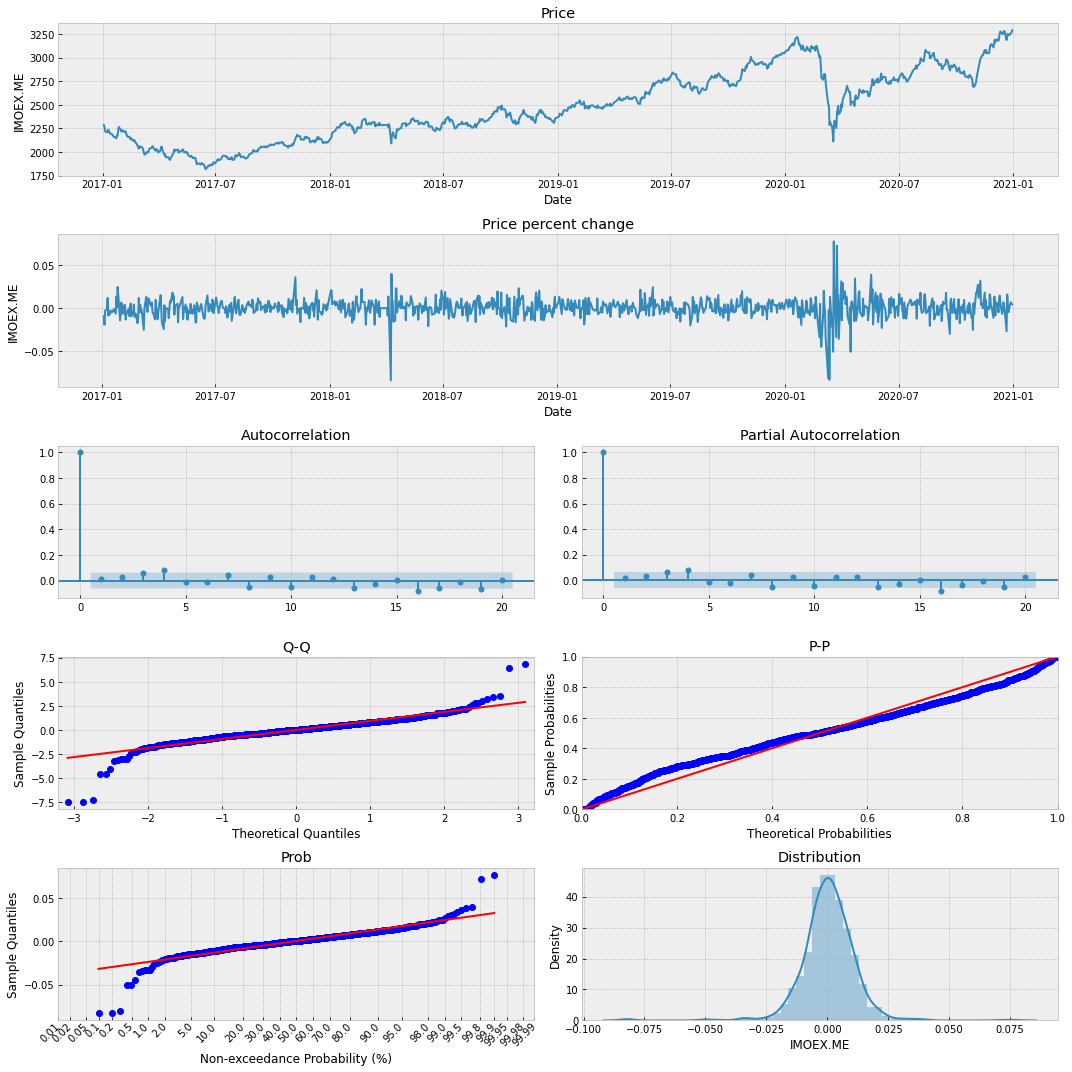

========== BZ=F ==========
mean: 58.54
std: 12.76
min: 19.33
max: 86.29
The Augmented Dickey-Fuller test, p-value: 0.29558777916016676, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.646745792770896e-07, series is stationary


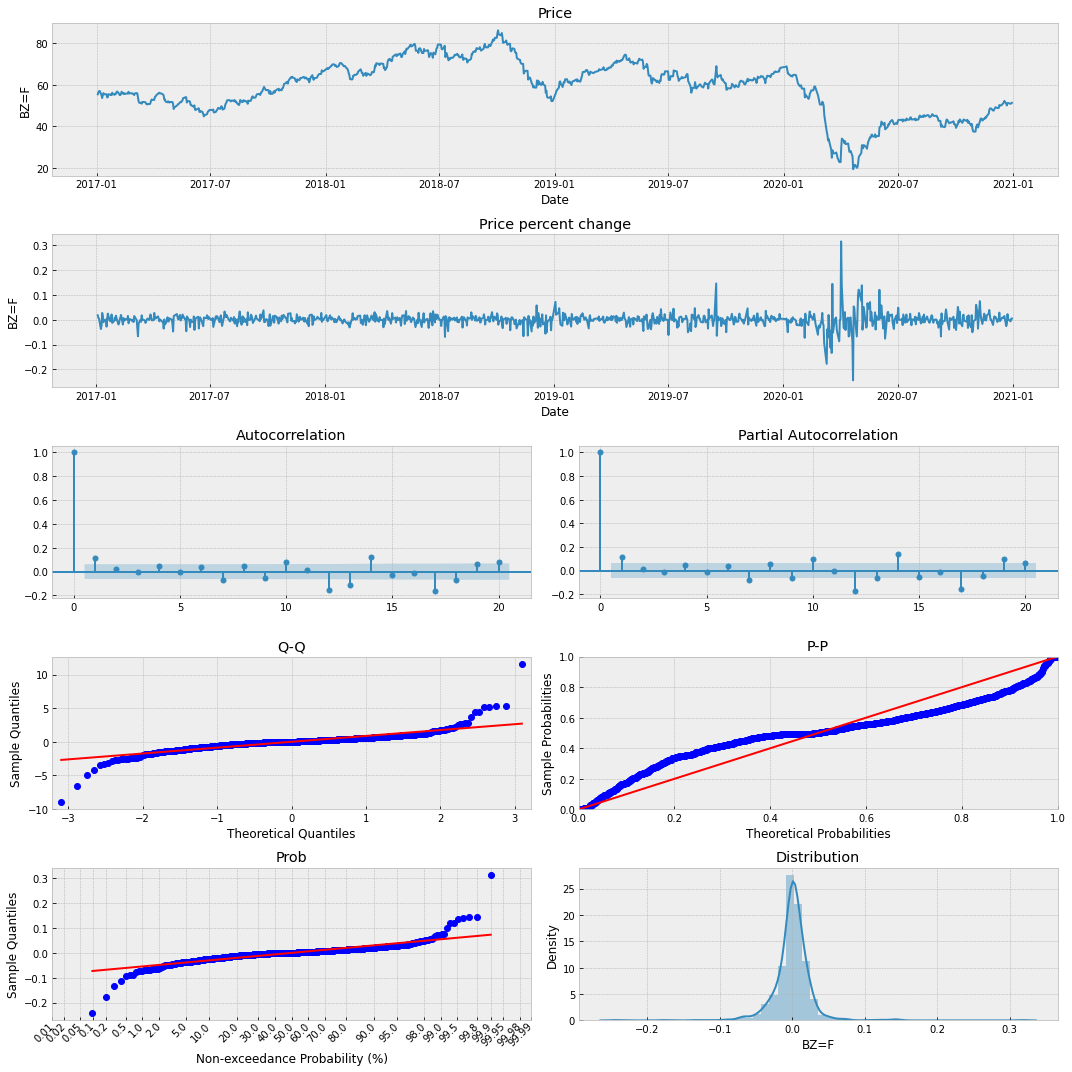

========== RTS ==========
mean: 1208.12
std: 133.8
min: 832.26
max: 1646.6
The Augmented Dickey-Fuller test, p-value: 0.2724882464435697, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.1400213521707747e-17, series is stationary


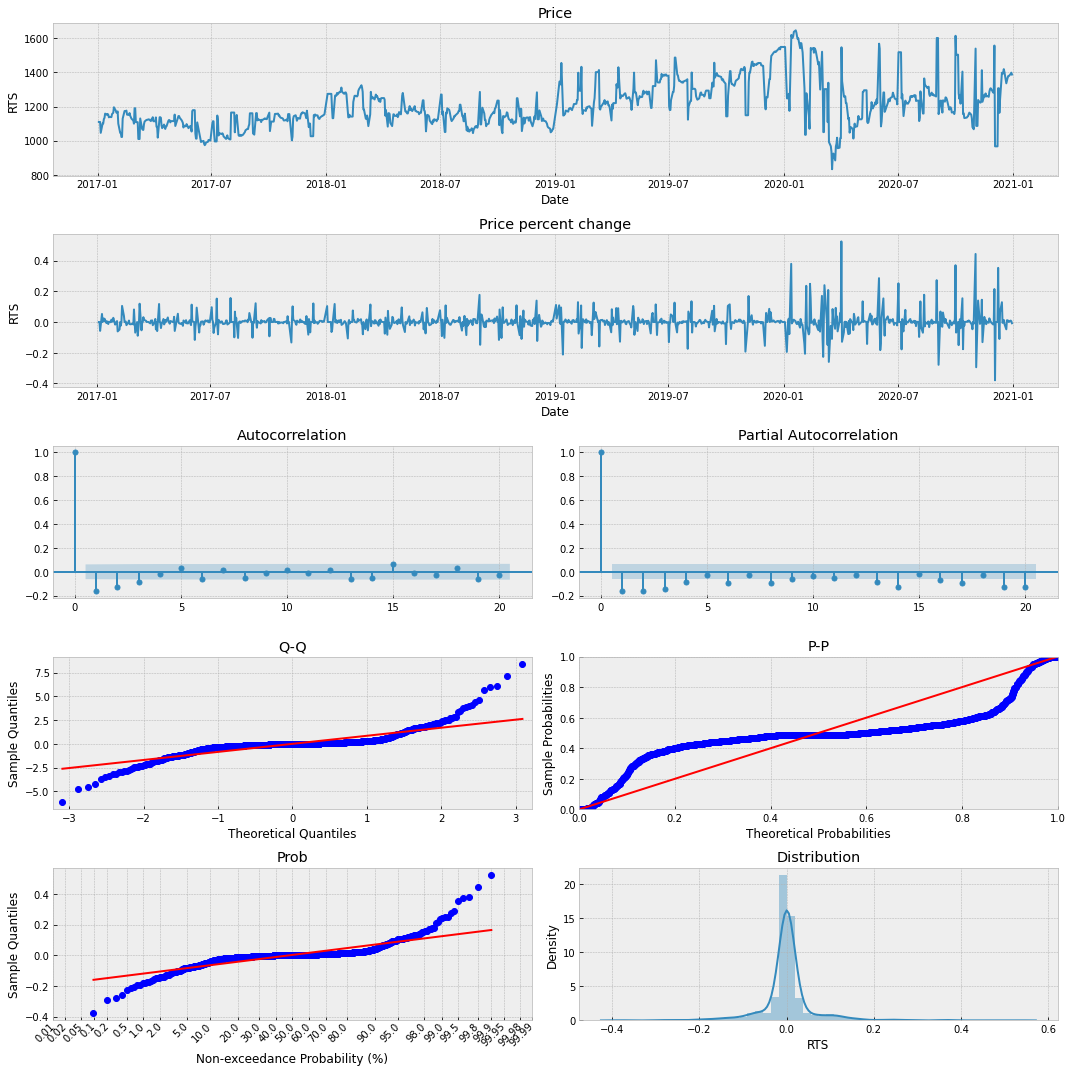

========== GOLD ==========
mean: 2983.32
std: 746.72
min: 2232.16
max: 4887.7
The Augmented Dickey-Fuller test, p-value: 0.970707983245699, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 0.0, series is stationary


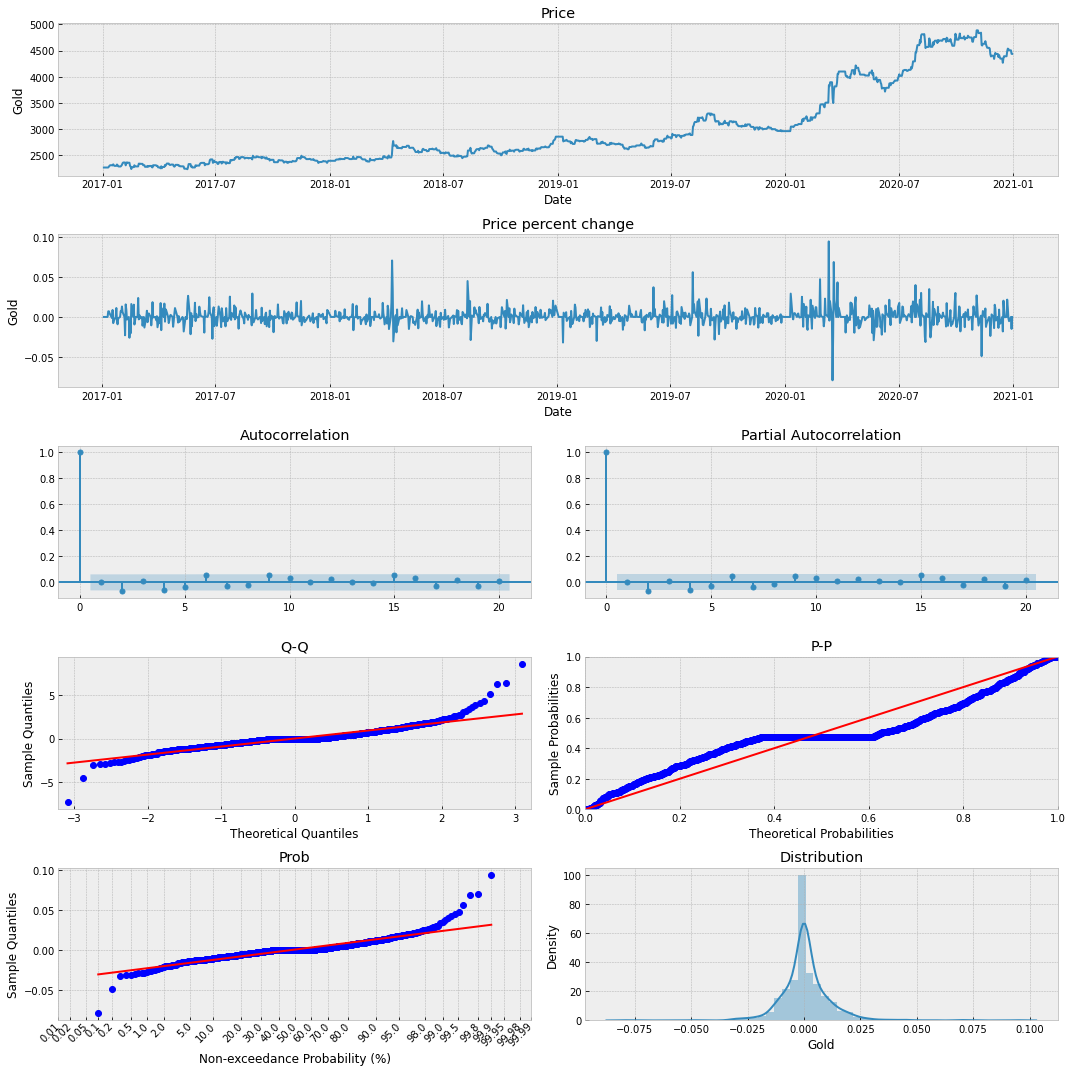

========== ARGENT ==========
mean: 36.29
std: 9.17
min: 29.51
max: 68.34
The Augmented Dickey-Fuller test, p-value: 0.943344377504336, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 6.698866653316022e-11, series is stationary


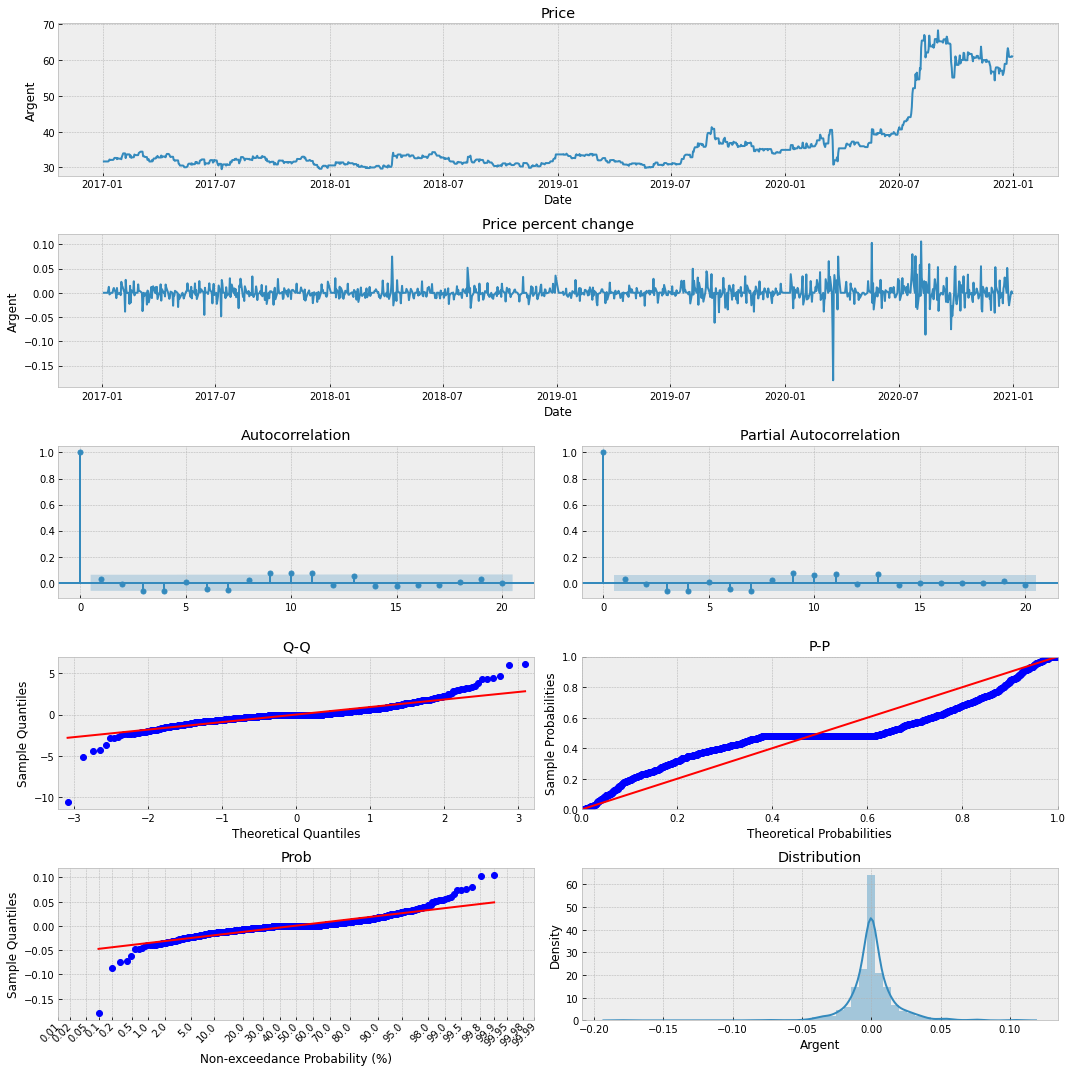

========== PLATINE ==========
mean: 1848.12
std: 170.84
min: 1522.76
max: 2473.81
The Augmented Dickey-Fuller test, p-value: 0.950871410902307, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.274893365112877e-27, series is stationary


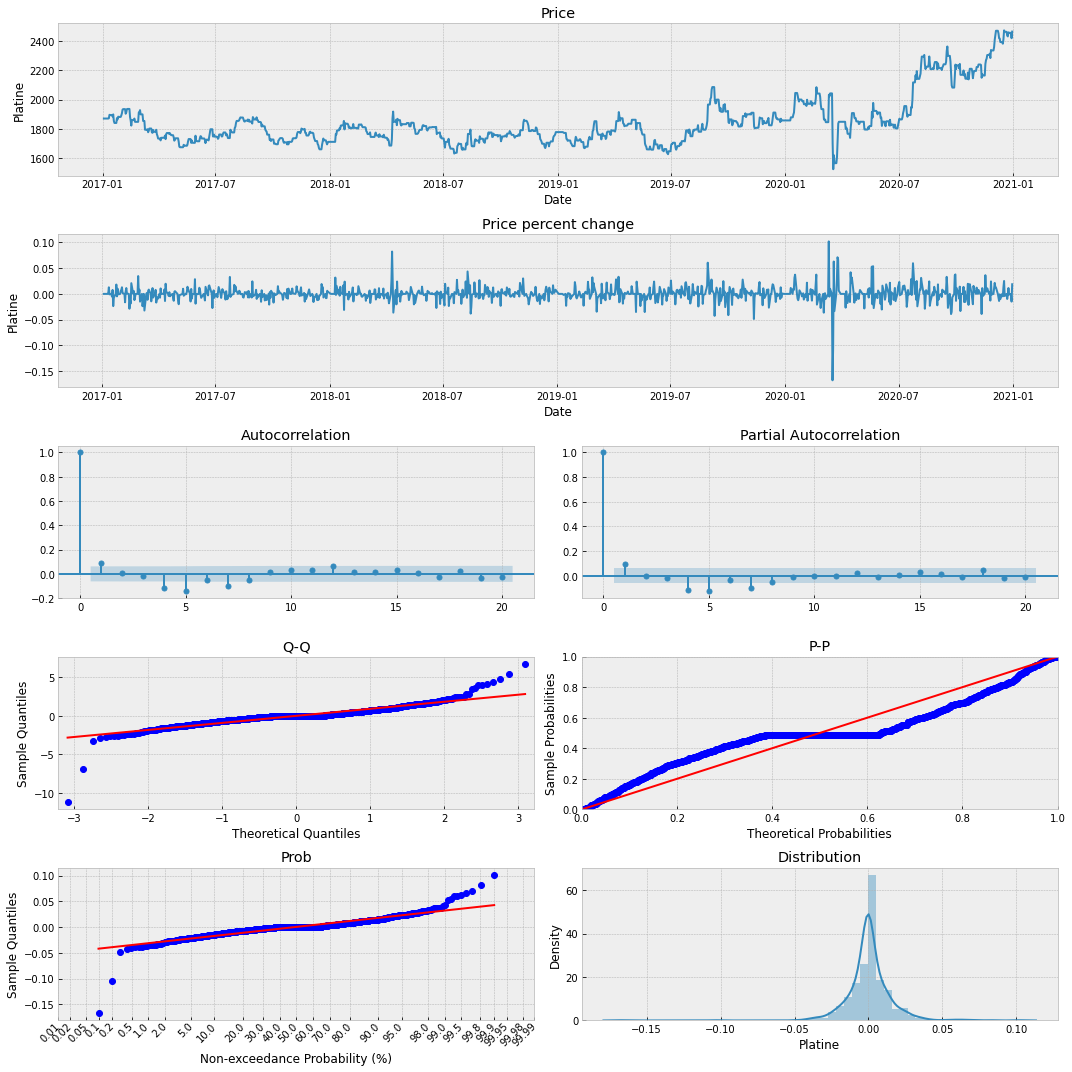

========== PALLADIUM ==========
mean: 2999.15
std: 1393.67
min: 1379.06
max: 6098.86
The Augmented Dickey-Fuller test, p-value: 0.9819060821375514, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.4455303781893872e-24, series is stationary


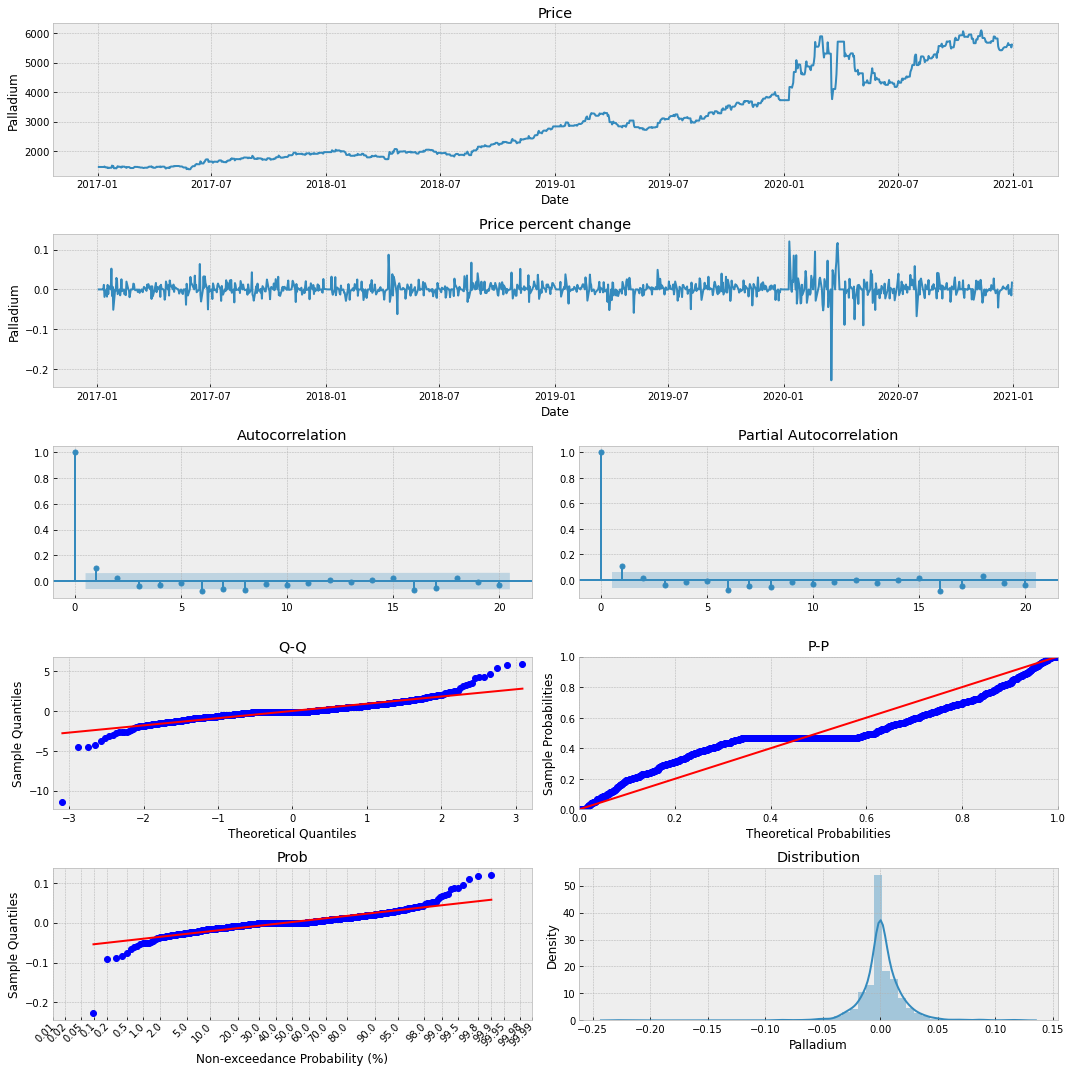

========== 0.25 ==========
mean: 6.62
std: 1.46
min: 3.68
max: 9.82
The Augmented Dickey-Fuller test, p-value: 0.9145344034994012, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 0.0, series is stationary


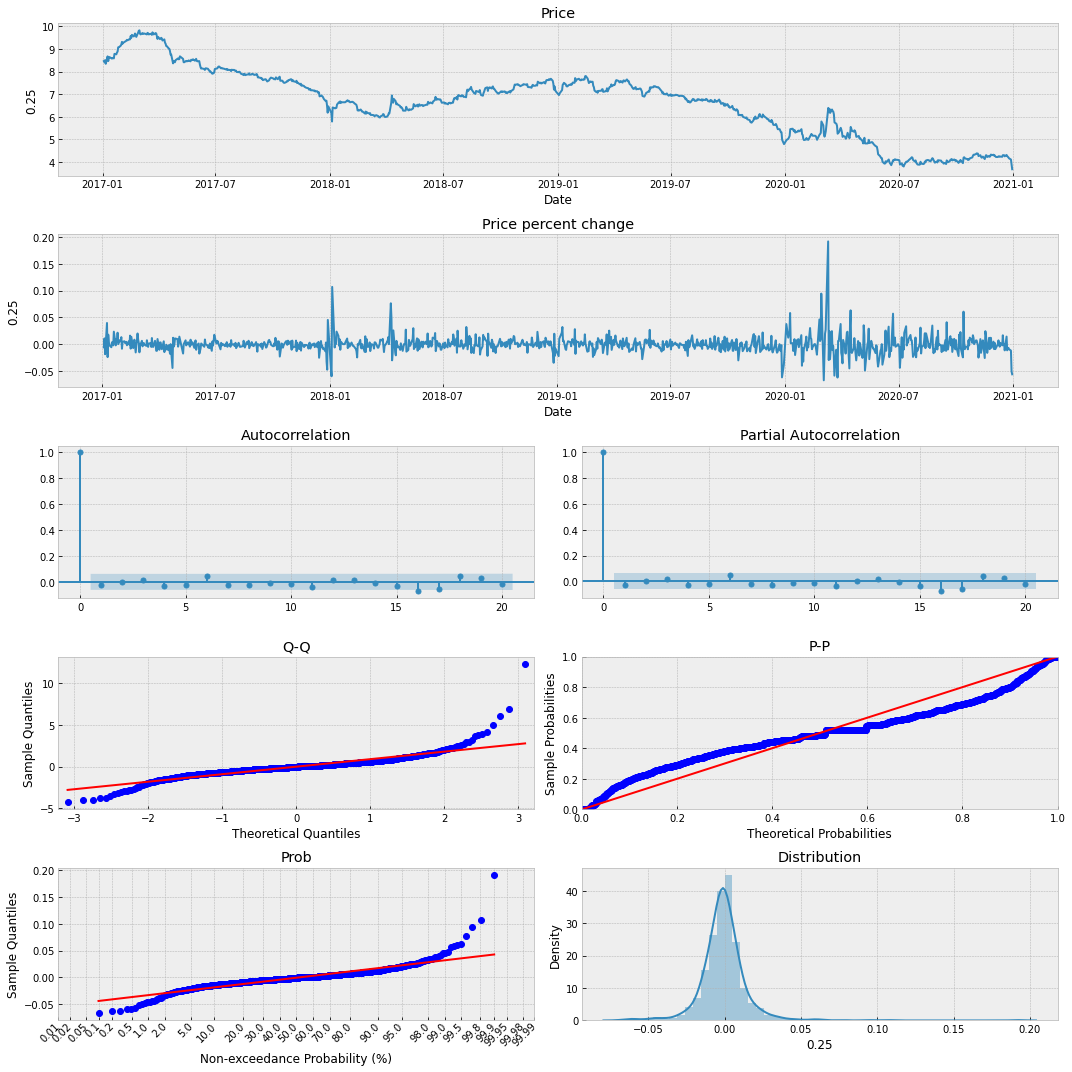

========== 0.5 ==========
mean: 6.64
std: 1.42
min: 3.87
max: 9.51
The Augmented Dickey-Fuller test, p-value: 0.9143124925299795, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 0.0, series is stationary


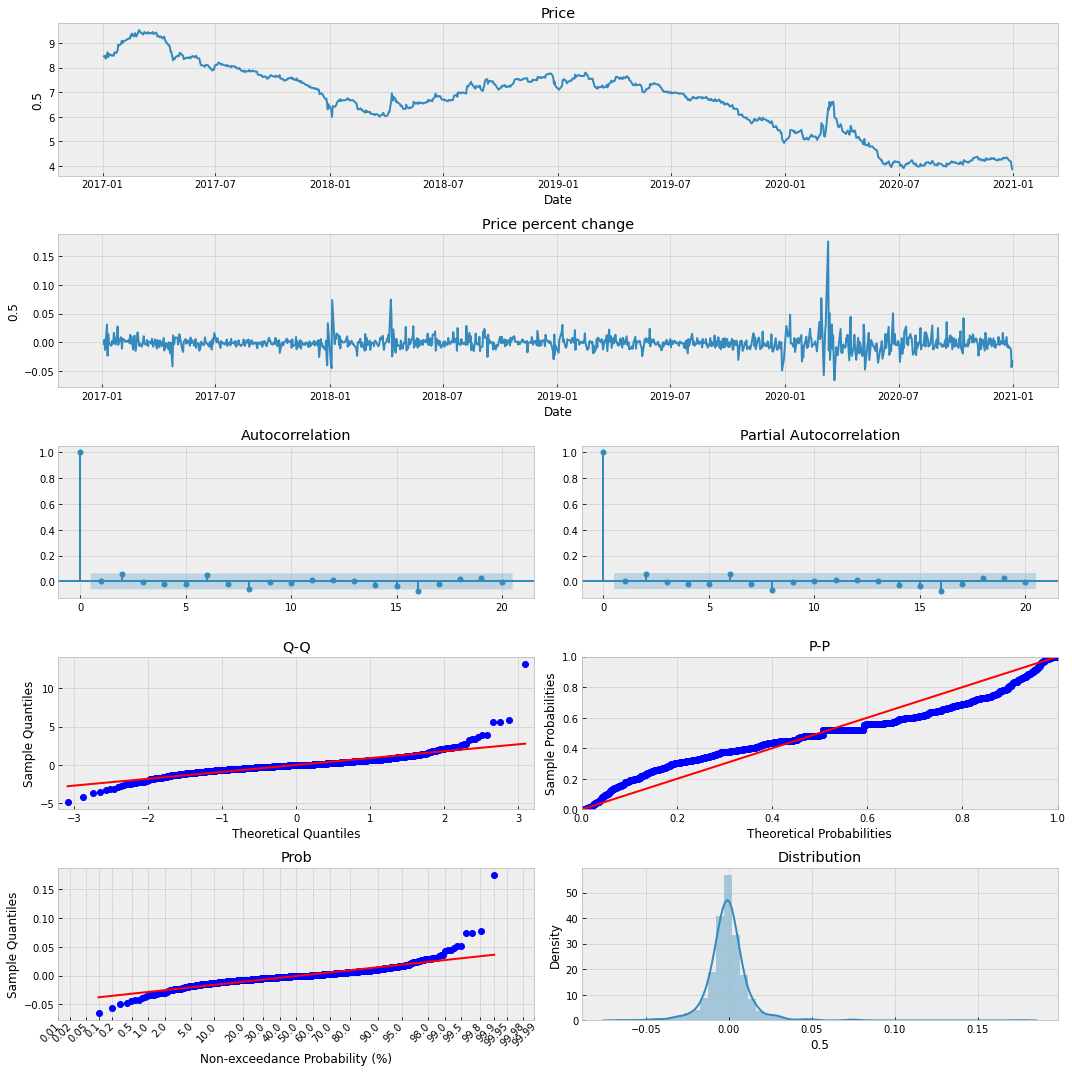

========== 0.75 ==========
mean: 6.66
std: 1.38
min: 4.02
max: 9.27
The Augmented Dickey-Fuller test, p-value: 0.9021490752383663, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.2920823550687052e-21, series is stationary


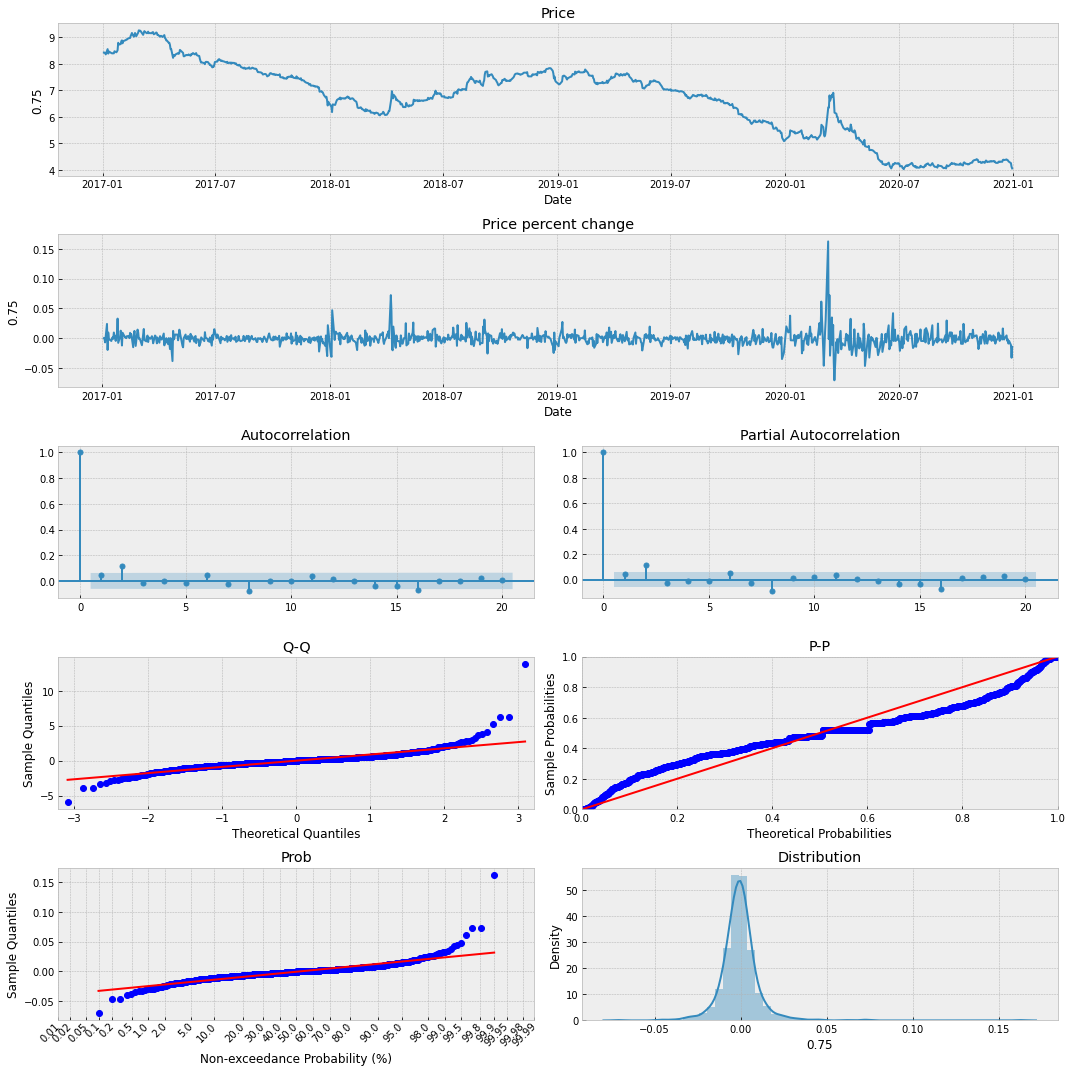

========== 1 ==========
mean: 6.69
std: 1.35
min: 4.12
max: 9.1
The Augmented Dickey-Fuller test, p-value: 0.9242625911753577, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 7.835691975405049e-22, series is stationary


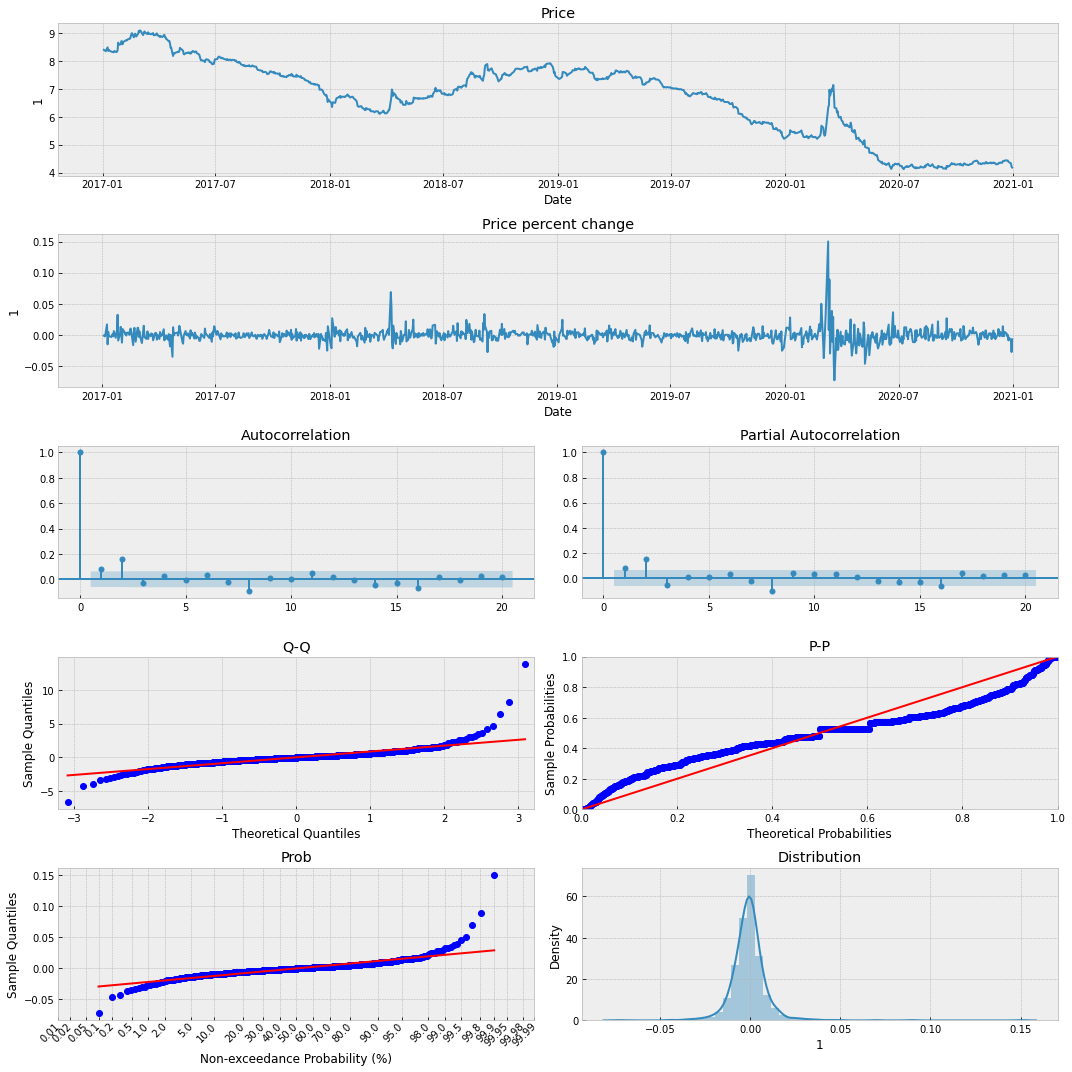

========== 2 ==========
mean: 6.8
std: 1.25
min: 4.38
max: 8.68
The Augmented Dickey-Fuller test, p-value: 0.9097458147543342, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.093441976351696e-21, series is stationary


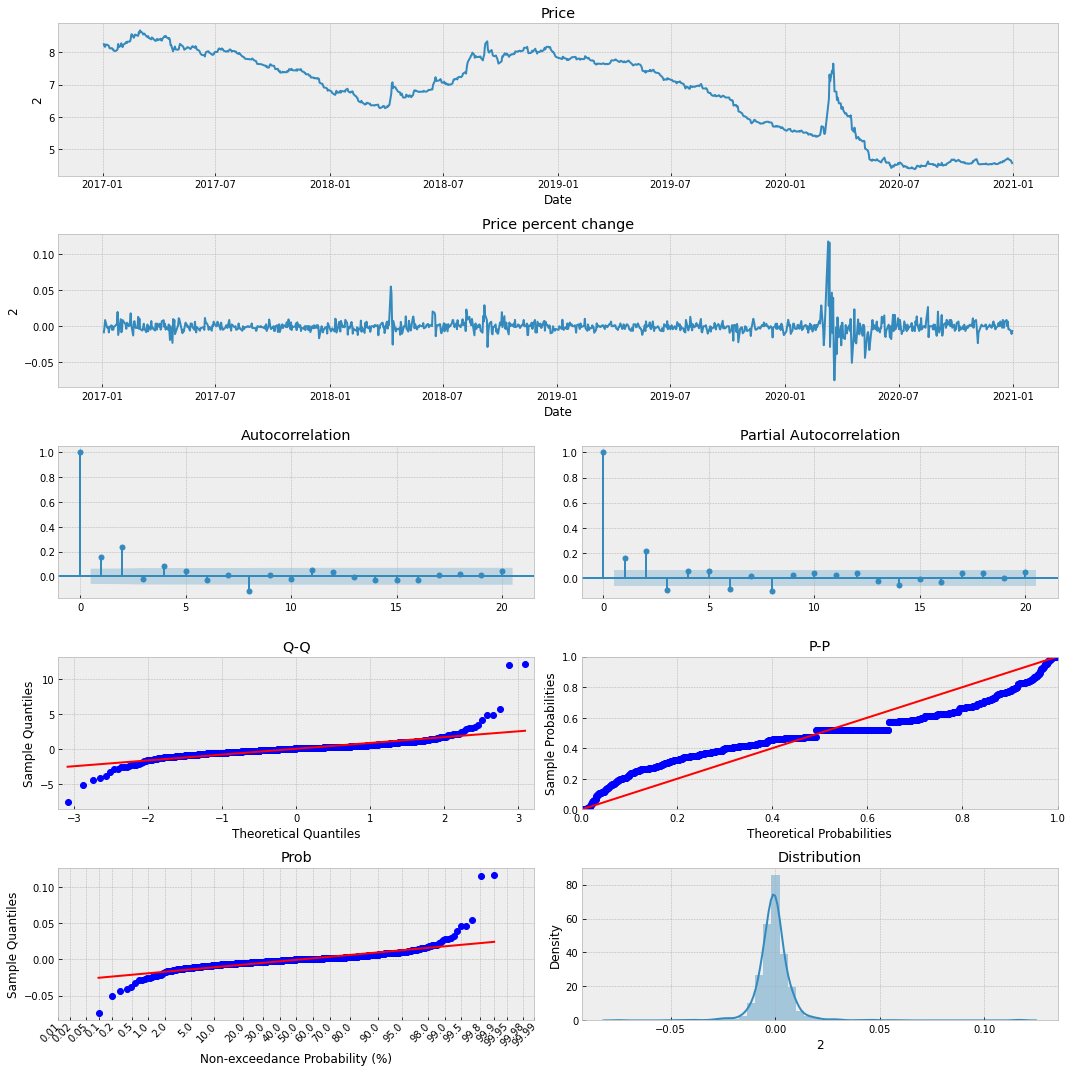

========== 3 ==========
mean: 6.9
std: 1.18
min: 4.6
max: 8.65
The Augmented Dickey-Fuller test, p-value: 0.871143923257319, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.9097597993308758e-20, series is stationary


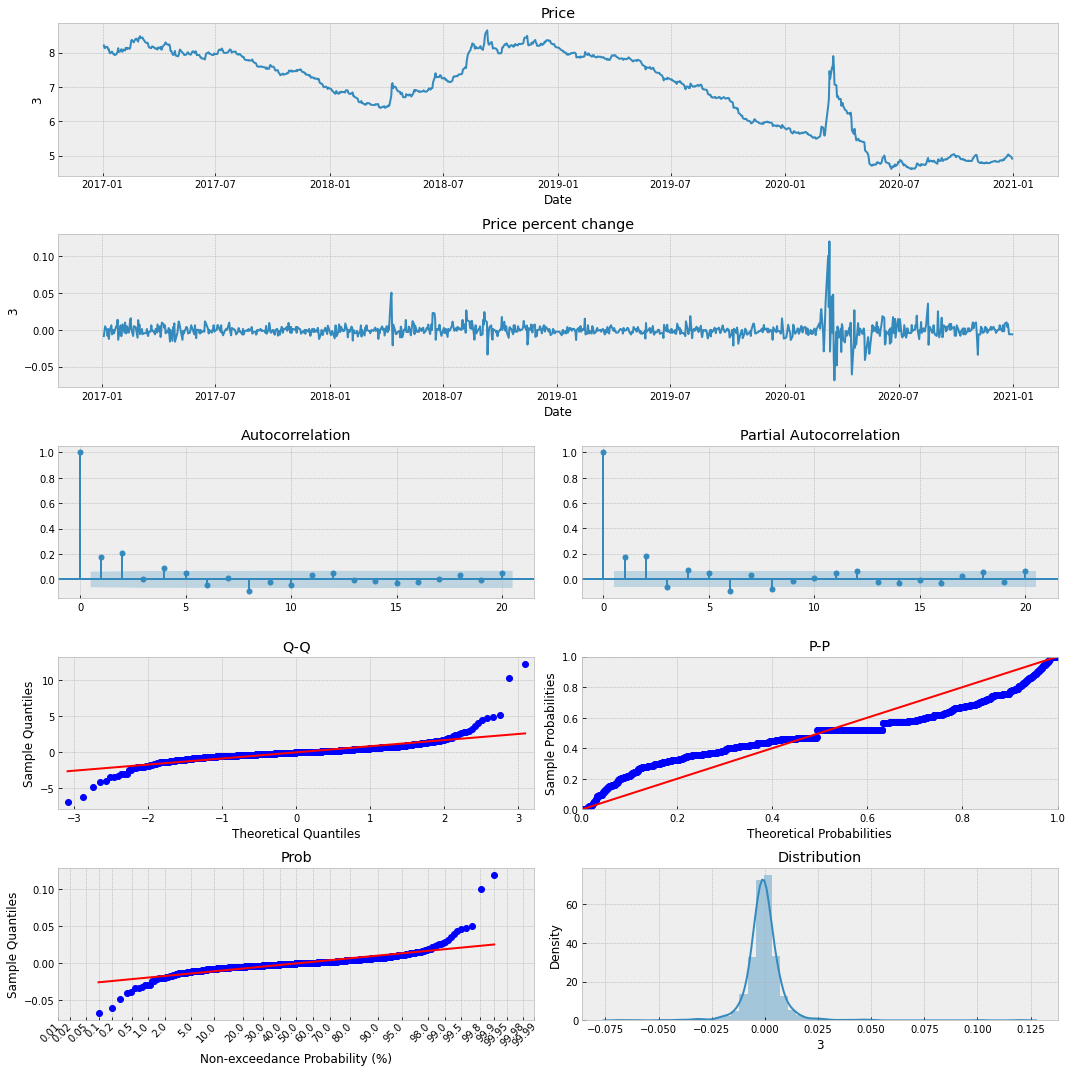

========== 5 ==========
mean: 7.09
std: 1.06
min: 4.95
max: 9.02
The Augmented Dickey-Fuller test, p-value: 0.7514487725858088, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.3857709635609386e-14, series is stationary


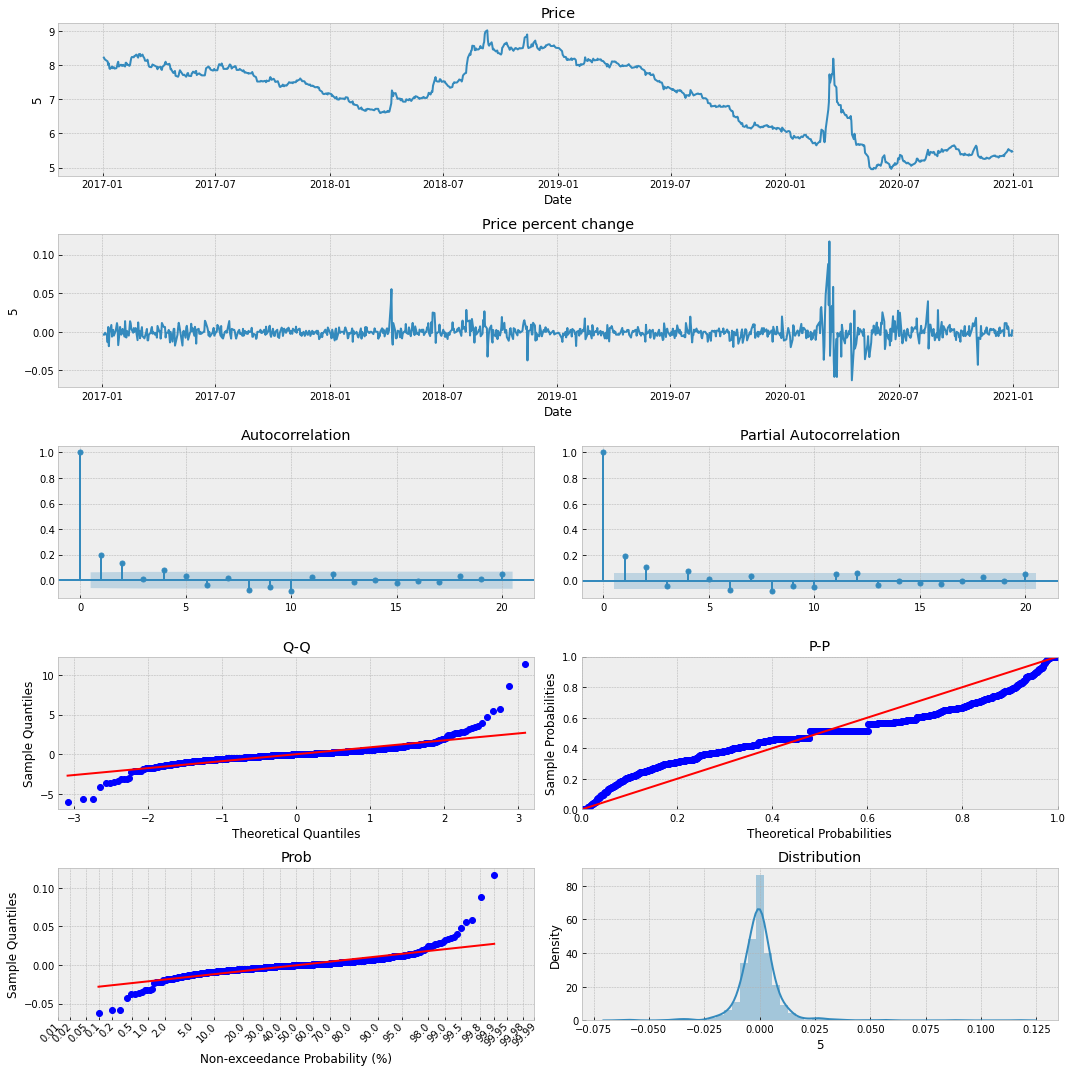

========== 7 ==========
mean: 7.24
std: 0.97
min: 5.22
max: 9.19
The Augmented Dickey-Fuller test, p-value: 0.7010514948984194, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 3.1238998045579063e-15, series is stationary


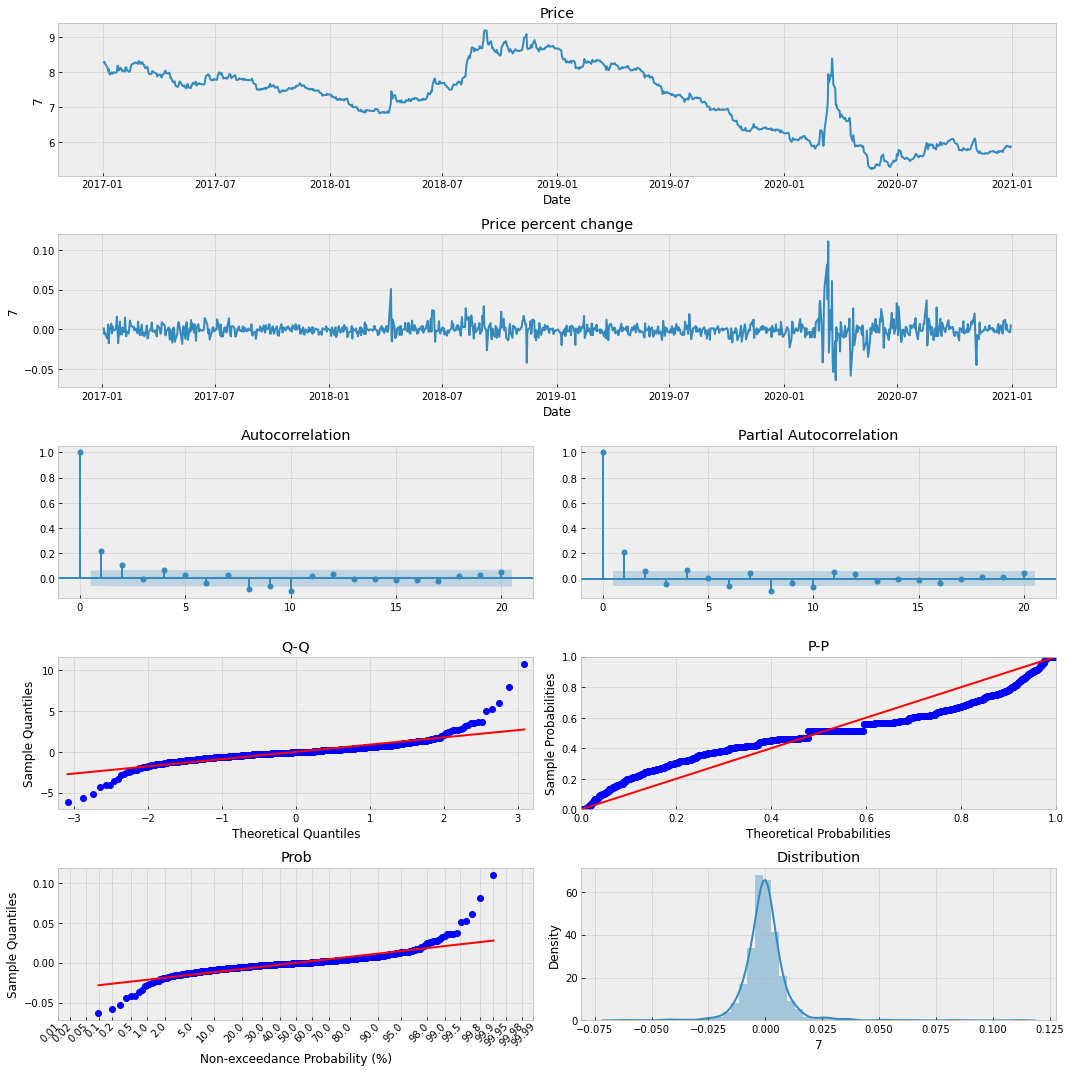

========== 10 ==========
mean: 7.43
std: 0.88
min: 5.59
max: 9.29
The Augmented Dickey-Fuller test, p-value: 0.6629083396090492, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.5376638081806754e-17, series is stationary


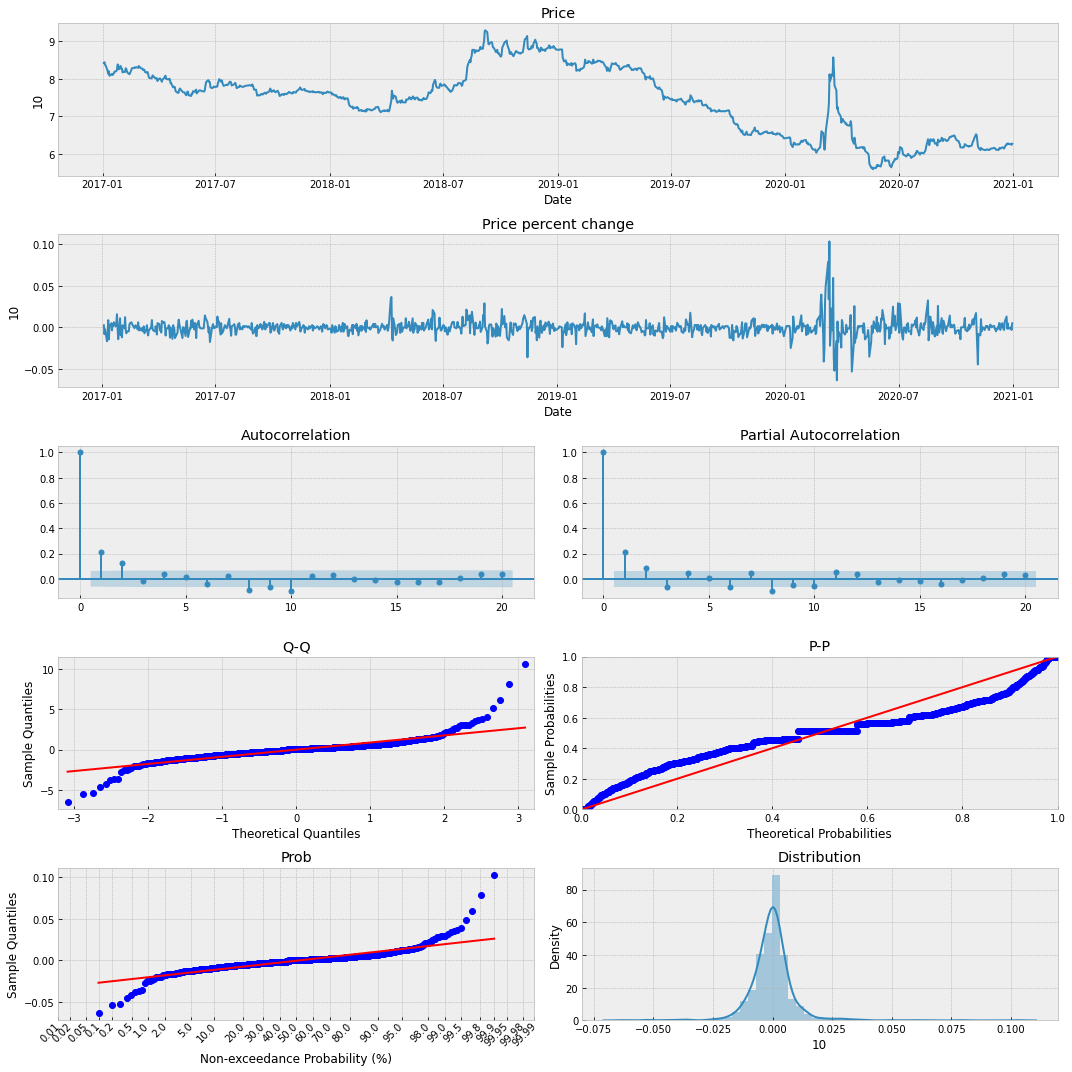

========== 15 ==========
mean: 7.66
std: 0.81
min: 5.97
max: 9.26
The Augmented Dickey-Fuller test, p-value: 0.6139933089641, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.288093762530581e-17, series is stationary


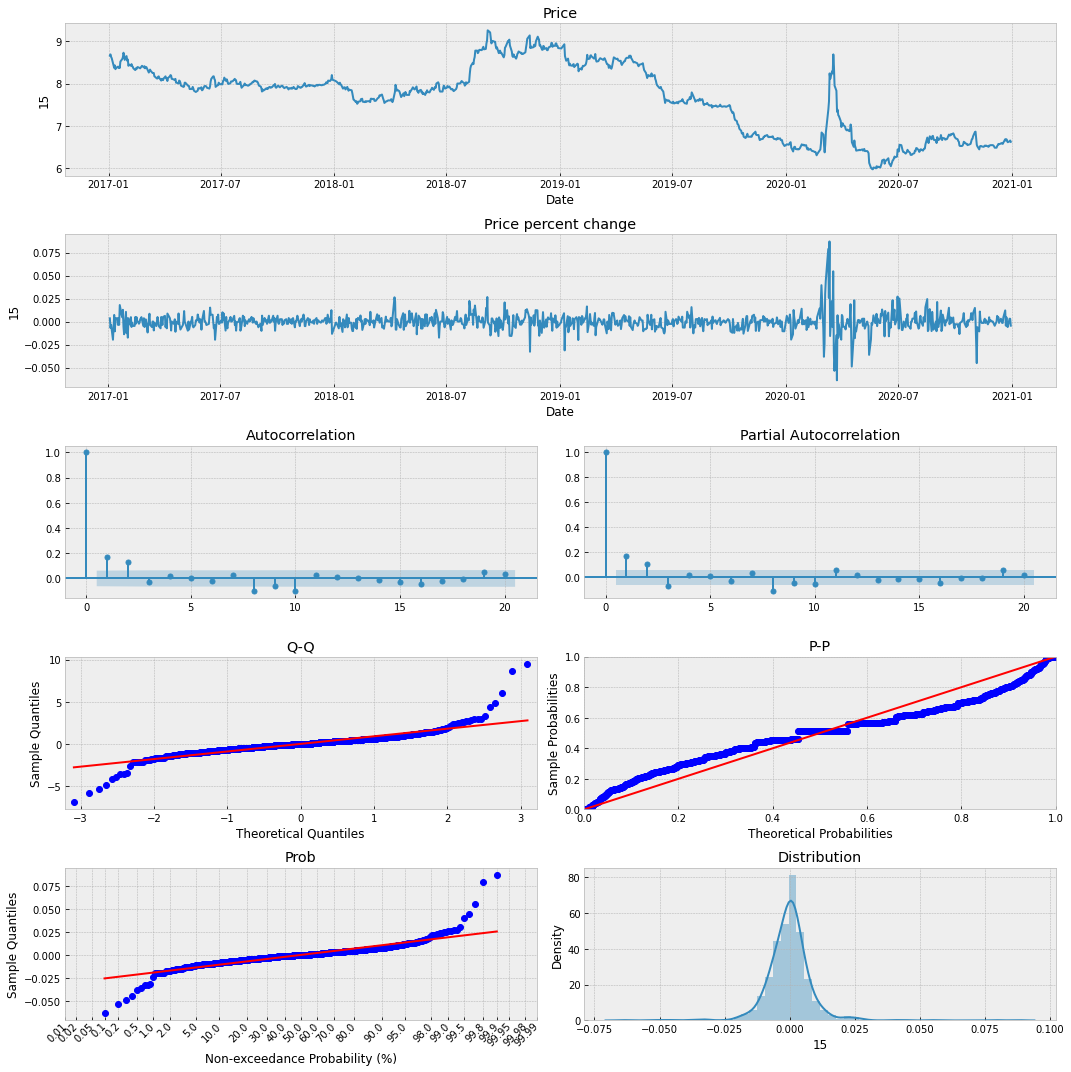

========== 20 ==========
mean: 7.84
std: 0.79
min: 6.17
max: 9.2
The Augmented Dickey-Fuller test, p-value: 0.601541555046818, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 6.250820276205768e-18, series is stationary


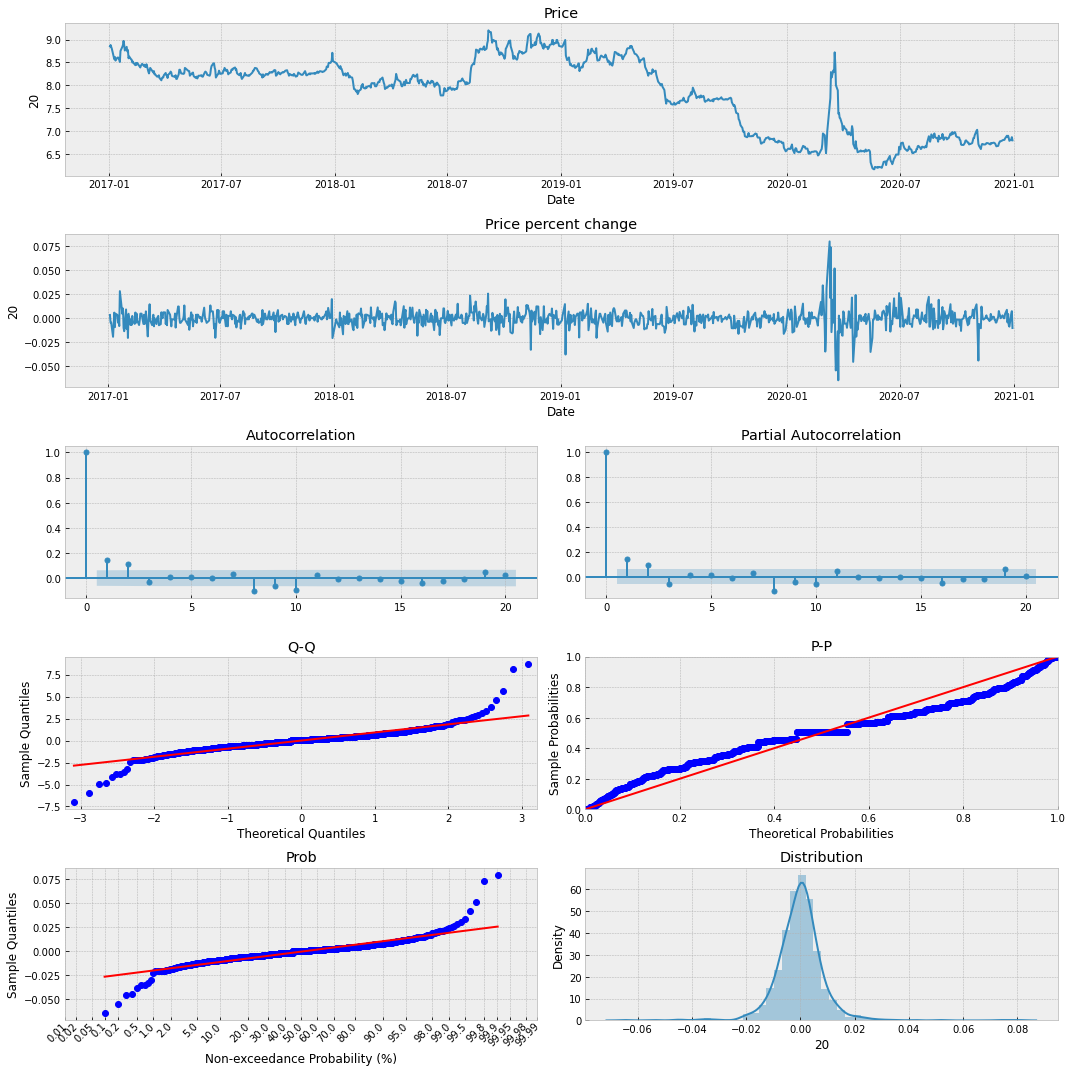

========== 30 ==========
mean: 8.09
std: 0.85
min: 6.37
max: 9.57
The Augmented Dickey-Fuller test, p-value: 0.6419590589333192, series is non stationary
The Augmented Dickey-Fuller test for pct change, p-value: 1.9450796854748026e-20, series is stationary


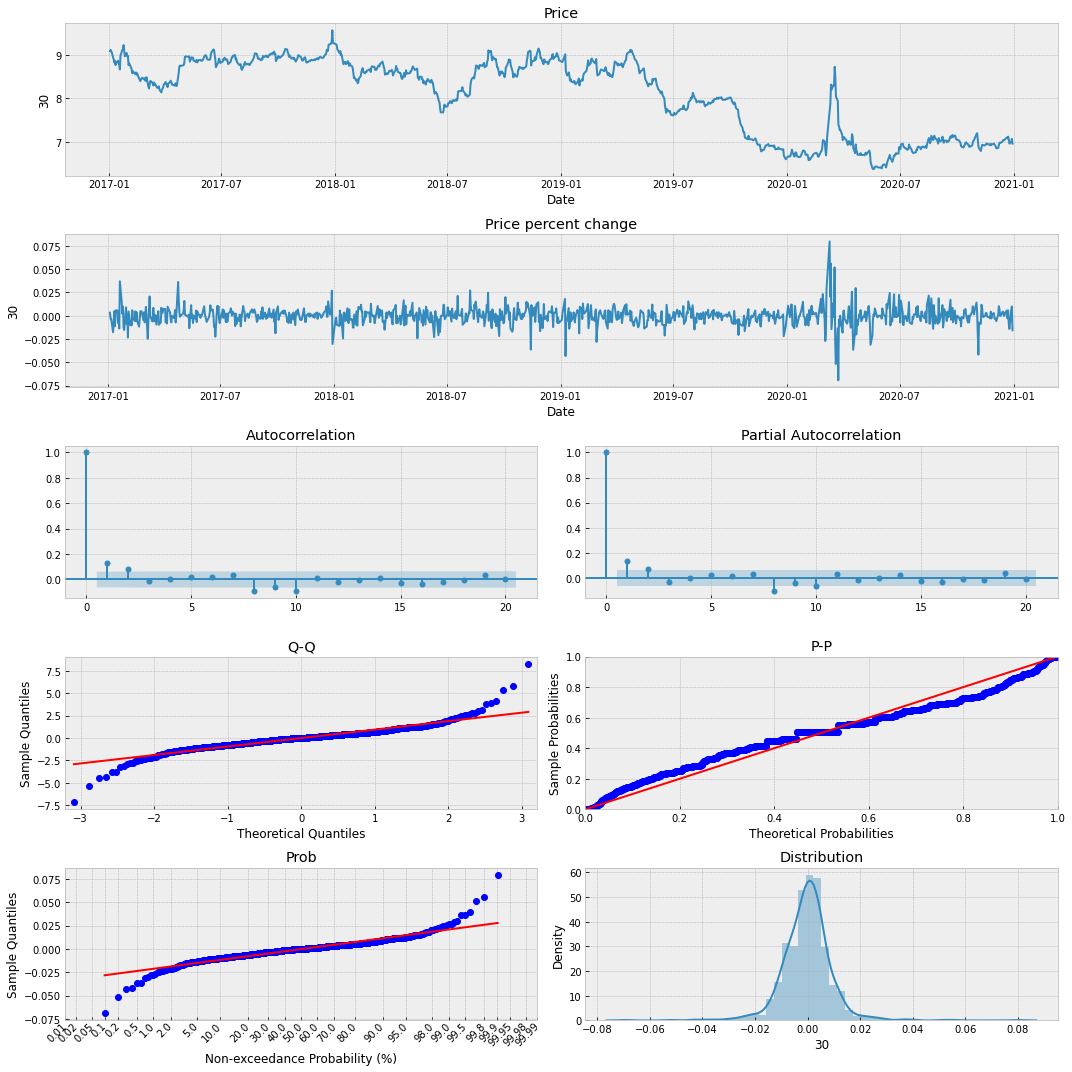

In [8]:
for col in risk_factors.columns:
    risk_factor_describe(risk_factors[col])

# 5. Составляем портфель и перебалансируем на каждый день

In [9]:
obligation_coupons_files = ['bonds\SU26205RMFS3.csv', 'bonds\SU26209RMFS5.csv', 'bonds\SU26212RMFS9.csv', 
                            'bonds\SU26215RMFS2.csv', 'bonds\SU26217RMFS8.csv']
def payment_per_day_bonds(obligation_coupons_files=obligation_coupons_files):

    obligation_coupons = []
    for i in range(len(obligation_coupons_files)):
        obligation_coupon = pd.read_csv(obligation_coupons_files[i])
        obligation_coupon.date = pd.to_datetime(obligation_coupon.date)
        days = (obligation_coupon[['date']].iloc[-2] \
                - obligation_coupon[['date']].iloc[-3]).values[0].astype('timedelta64[D]').astype(int)
        payment_per_day = obligation_coupon['payment'].iloc[-2] / days
        obligation_coupons.append(payment_per_day)

    return np.round(obligation_coupons, 5)

In [10]:
def calculate_portfolio_distribution(bonds=bonds, 
                                     shares=shares, 
                                     currencies=currencies):
    
    dirty_bonds = bonds + payment_per_day_bonds()
    df_for_portfolio = dirty_bonds.join((shares, currencies), how='left')
    
    position_0 = np.array([10e6] * 5 + [1e6] * 10 + [10e6] * 2)
    day_prices = df_for_portfolio.iloc[0] 
    true_qty = position_0 / day_prices
    qty = np.round(position_0 / day_prices, 0).astype(int)
    portfolio_qty_shares_true = (true_qty * day_prices) / (true_qty * day_prices).sum()
    
    all_qty = qty
    all_price = day_prices
    
    for t in range(1, df_for_portfolio.shape[0]):
        day_prices = df_for_portfolio.iloc[t-1]
        wts = (qty * day_prices) / np.sum(qty * day_prices)
        delta_wts = portfolio_qty_shares_true / wts
        qty = np.round(qty * delta_wts, 0).astype(int)
        all_qty = np.vstack((all_qty, qty))
        all_price = np.vstack((all_price, day_prices))
    
    number_of_assets = pd.DataFrame(all_qty, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    prices_of_assets = pd.DataFrame(all_price, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    total_sum = pd.DataFrame(all_qty*all_price, columns=df_for_portfolio.columns, index=dirty_bonds.index)
    
    return number_of_assets, prices_of_assets, total_sum

In [11]:
number_of_assets, prices_of_assets, sum_portfolio = calculate_portfolio_distribution()

In [12]:
ret = prices_of_assets.pct_change()
ret.dropna(inplace=True)

bonds_ret = ret.iloc[:, 0:5]
shares_ret = ret.iloc[:, 5:15]
currencies_ret = ret.iloc[:, 15:17]

# Считаем VaR и ES

In [168]:
def calc_VaR_and_ES(r, VaR_fun, L_history=170, level_VaR=0.01, level_ES=0.025, horizon=1):
    VaR, VaR_for_ES, ES = np.full(r.shape[0], np.nan), np.full(r.shape[0], np.nan), np.full(r.shape[0], np.nan)
    
    for i in tqdm(range(L_history, len(r))):
        history = r[i - L_history: i]
        h = np.dot(history, np.array([1/r.shape[1] for x in range(r.shape[1])]))
        VaR[i] = VaR_fun(h, level_VaR, horizon) 
        if VaR[i] < -0.25:
            VaR[i] = VaR[i-1]
        VaR_for_ES[i] = VaR_fun(h, level_ES, horizon) 
        
        ES[i] = h[h < VaR_for_ES[i]].mean()
    
    VaR = pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__) 
    ES = pd.Series(data=ES, index=r.index, name=VaR_fun.__name__)  
    
    return VaR, ES

def calculate_VaR_HS(ret, alpha=0.01, horizon=1):

    return np.quantile(ret, alpha)

def calculate_VaR_garch(returns, alpha, h=1):
    scaling_const = 10 / returns.std()
    mdl = arch_model(returns * scaling_const,
                    mean='Constant', lags=1, 
                    vol='GARCH', p=1, o=1, 
                    q=1, dist='skewt') 
    
    res = mdl.fit(disp='off', show_warning=False)

    forecasts = res.forecast(horizon=h)
    
    
    cond_mean = float(forecasts.mean.iloc[-1].mean())
    cond_var = float(forecasts.variance.iloc[-1].mean())

    q = mdl.distribution.ppf(alpha, res.params[-2:])

    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

### Облигации

In [161]:
VaR_bonds_1, ES_bonds_1 = calc_VaR_and_ES(bonds_ret, calculate_VaR_garch, L_history=170, 
                                                    level_VaR=0.01, level_ES=0.025, horizon=1)
VaR_bonds_10, ES_bonds_10 = calc_VaR_and_ES(bonds_ret, calculate_VaR_garch, L_history=170, 
                                                         level_VaR=0.01, level_ES=0.025, horizon=10)

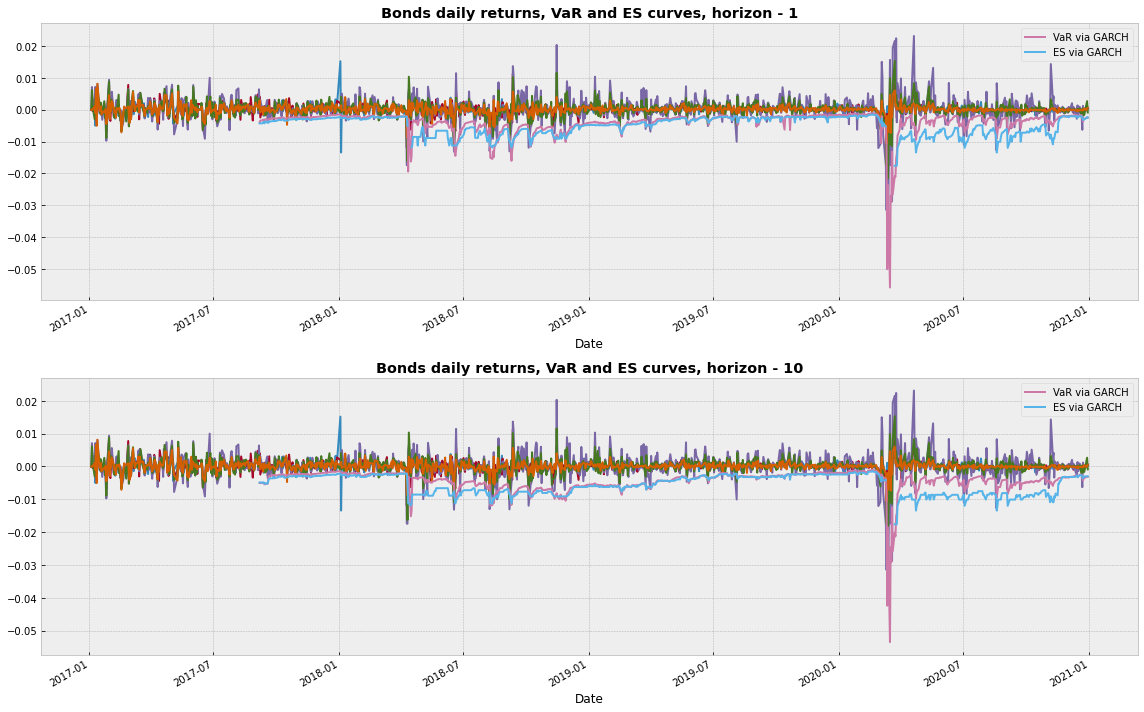

In [162]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.plot(bonds_ret)
VaR_bonds_1.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_bonds_1.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Bonds daily returns, VaR and ES curves, horizon - 1", weight="bold")
plt.legend()

plt.subplot(212)
plt.plot(bonds_ret)
VaR_bonds_10.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_bonds_10.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Bonds daily returns, VaR and ES curves, horizon - 10", weight="bold")
plt.legend()

plt.tight_layout()
plt.show()

In [171]:
def plot_hist_GARCH(data, data_name, VaR_level=0.01, ES_level=0.025, horizon = (1, 10)):
    fig = plt.figure(figsize=(16, 5*len(horizon)))
    
    ret = data.mean(axis=1)
    scaling_const = 10 / ret.std()
    
    mdl = arch_model(y=ret * scaling_const,
                mean='Constant', lags=1, 
                vol='GARCH', p=1, o=1, q=1, 
                dist='skewt') 
    res = mdl.fit(disp = 'off')
    
    for i, h in enumerate(horizon):
        forecasts = res.forecast(horizon=h)
        cond_mean = float(forecasts.mean.iloc[-1].mean())
        cond_var = float(forecasts.variance.iloc[-1].mean())
        
        q_var = mdl.distribution.ppf(VaR_level, res.params[-2:])
        VaR = (cond_mean + np.sqrt(cond_var) * q_var) / scaling_const
        
        q_es = mdl.distribution.ppf(VaR_level, res.params[-2:])
        VaR_for_ES = (cond_mean + np.sqrt(cond_var) * q_es) / scaling_const
        
        ES_garch = ret[ret < VaR_for_ES].mean()
        
        plt.subplot(len(horizon), 1, i+1)
        
        sns.distplot(ret[ret >= VaR], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

        sns.distplot(ret[ret < VaR], hist=True, kde=False, 
                     bins=40,
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 4})

        plt.axvline(VaR, linewidth=4, color="r")
        plt.axvline(ES_garch, linewidth=4, color='r', linestyle='dashed')

        plt.title("Histogram of {} daily returns, horizon - {}".format(data_name, h), weight="bold")
        plt.legend(['GARCH VaR for alpha={}%: {:.2f}%'.format(VaR_level, 100*VaR),
                    'GARCH ES for alpha={}%: {:.2f}%'.format(ES_level, 100*ES_garch),
                    'Historical Returns Distribution', 
                    'Returns < VaR'], fontsize=12)

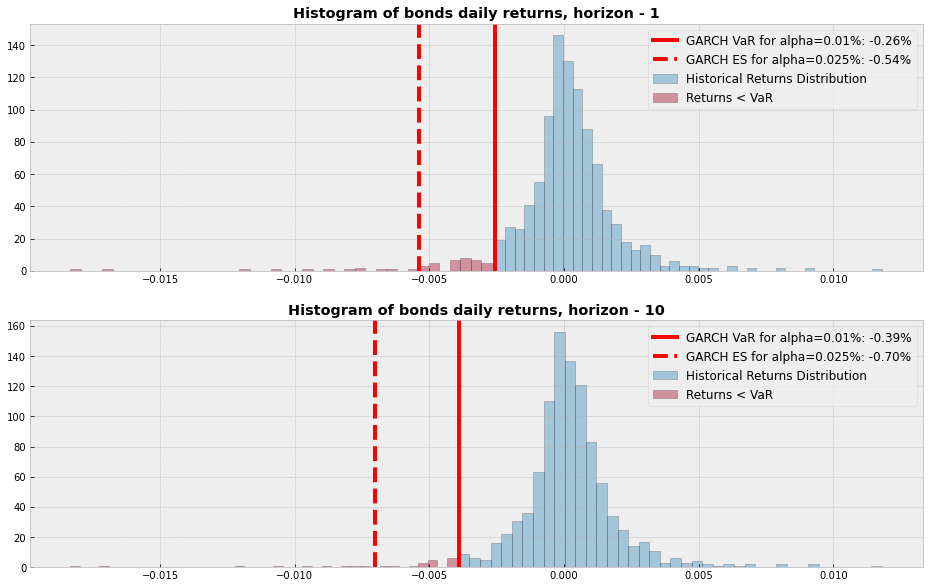

In [172]:
plot_hist_GARCH(bonds_ret, 'bonds')

### Акции

In [163]:
VaR_shares_1, ES_shares_1 = calc_VaR_and_ES(shares_ret, calculate_VaR_garch, L_history=170, 
                                                    level_VaR=0.01, level_ES=0.025, horizon=1)
VaR_shares_10, ES_shares_10 = calc_VaR_and_ES(shares_ret, calculate_VaR_garch, L_history=170, 
                                                         level_VaR=0.01, level_ES=0.025, horizon=10)

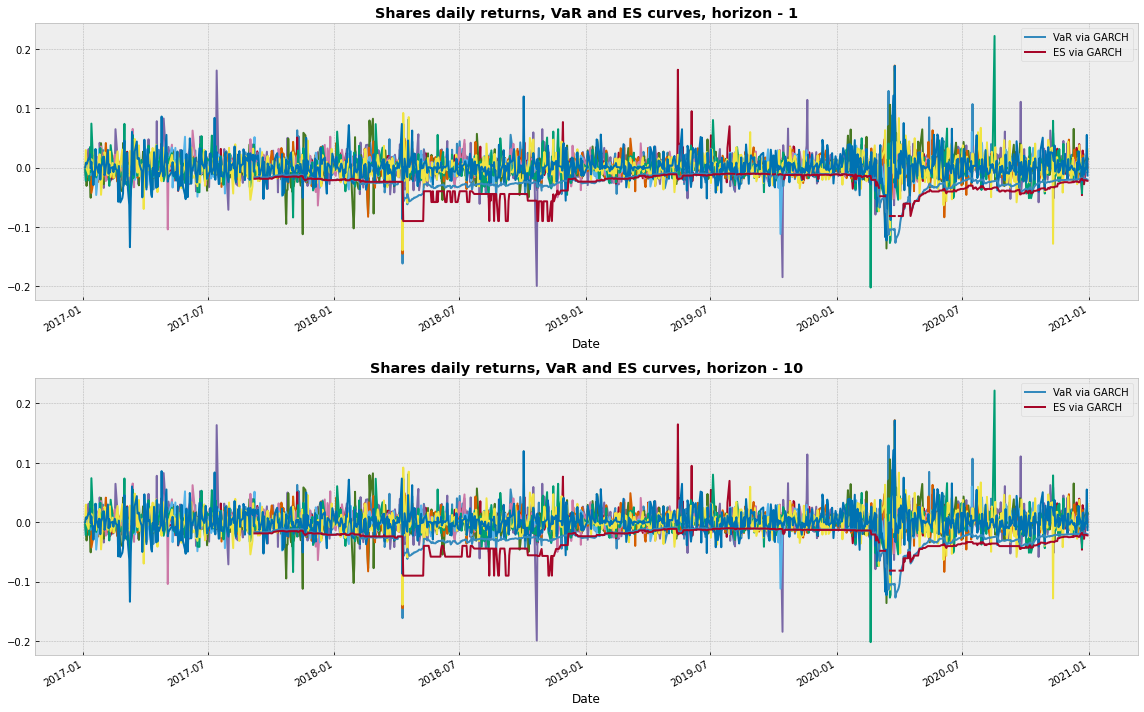

In [164]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.plot(shares_ret)
VaR_shares_1.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_shares_1.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Shares daily returns, VaR and ES curves, horizon - 1", weight="bold")
plt.legend()

plt.subplot(212)
plt.plot(shares_ret)
VaR_shares_10.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_shares_10.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Shares daily returns, VaR and ES curves, horizon - 10", weight="bold")
plt.legend()

plt.tight_layout()
plt.show()

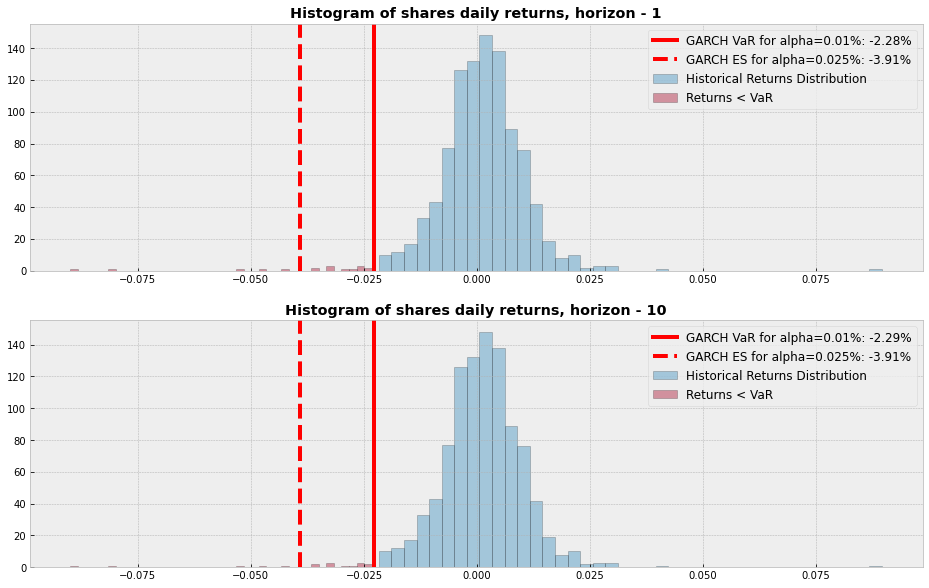

In [173]:
plot_hist_GARCH(shares_ret, 'shares')

### Валюты

In [169]:
VaR_currencies_1, ES_currencies_1 = calc_VaR_and_ES(currencies_ret, calculate_VaR_garch, L_history=170, 
                                                    level_VaR=0.01, level_ES=0.025, horizon=1)
VaR_currencies_10, ES_currencies_10 = calc_VaR_and_ES(currencies_ret, calculate_VaR_garch, L_history=170, 
                                                         level_VaR=0.01, level_ES=0.025, horizon=10)

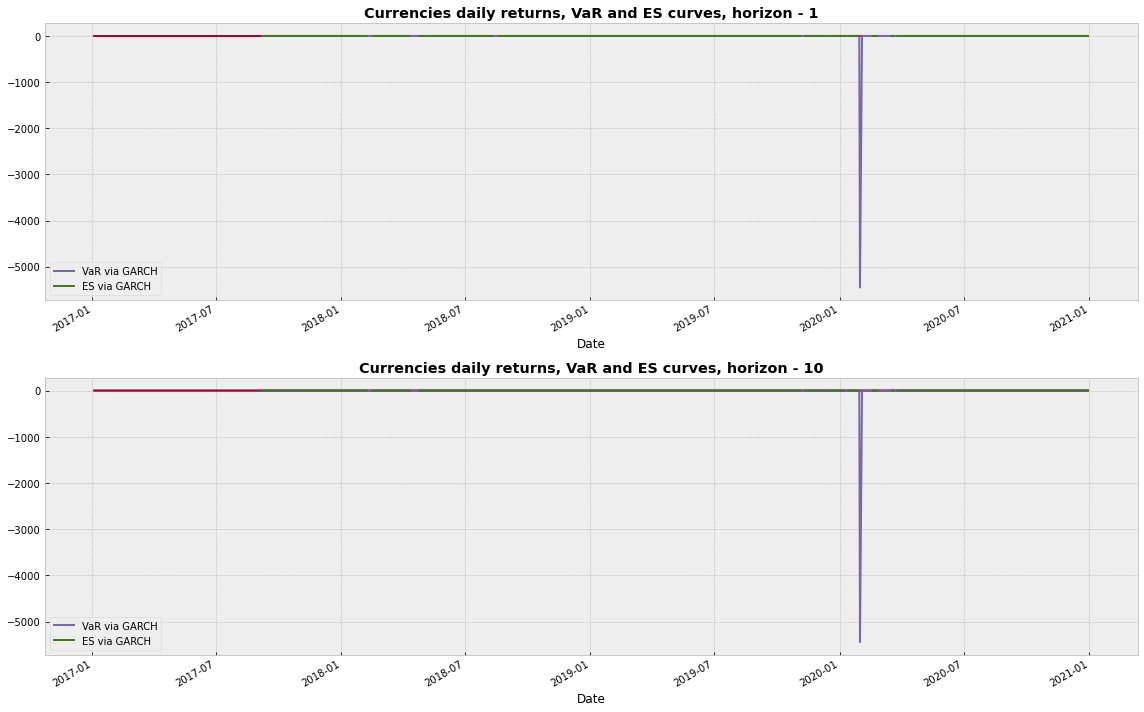

In [166]:
fig = plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.plot(currencies_ret)
VaR_currencies_1.plot(label = 'VaR via GARCH at alpha - 0.01')
ES_currencies_1.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Currencies daily returns, VaR and ES curves, horizon - 1", weight="bold")
plt.legend()

plt.subplot(212)
plt.plot(currencies_ret)
VaR_currencies_10.plot(label = 'VaR via GARCH at alpha - 0.01)
ES_currencies_10.plot(label = 'ES via GARCH at alpha - 0.025')

plt.title("Currencies daily returns, VaR and ES curves, horizon - 10", weight="bold")
plt.legend()

plt.tight_layout()
plt.show()

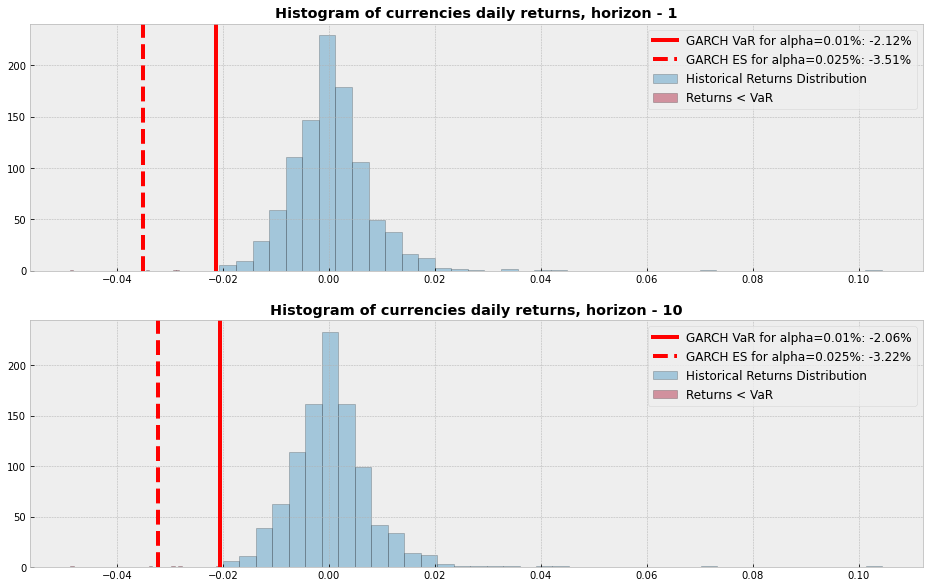

In [174]:
plot_hist_GARCH(currencies_ret, 'currencies')